## Лабортаторная работа №5

### По курсу "нейроинформатика"

студент: Гаврилов М.С.  
группа: М8О-406Б-19  

##### Цель работы:
Исследование свойств сетей Хопфилда, Хэмминга и Элмана, алгоритмов обучения, а также примерение сетей в задачах распознавания статических и динамических образов.

In [17]:
import numpy as np
import pylab
import copy

import torch
import torch.nn as nn
from tqdm import tqdm

### Задание 1. Рекурентная сеть Элмана

In [19]:
def func_p_2(k):
    return np.cos(-np.cos(k)*k**2 + k)
def func_p_1(k):
    return np.sin(4*np.pi*k)

h = 0.01
l = 4.55 - 2.9
r = [6,7,1]
ft = []
for i in np.arange(2.9,4.55,h):
    ft.append(func_p_2(i))

In [26]:
data_ii = []
data_xx = []
data_yy = []

pt_cnt = 0

for i in np.arange(0,r[0],0.01):
    data_ii.append([pt_cnt])
    data_xx.append([func_p_1(i)])
    data_yy.append([-1])
    pt_cnt+=1
    
for i in (ft):
    data_ii.append([pt_cnt])
    data_xx.append([i])
    data_yy.append([1])
    pt_cnt+=1
    
for i in np.arange(0,r[1],0.01):
    data_ii.append([pt_cnt])
    data_xx.append([func_p_1(i)])
    data_yy.append([-1])
    pt_cnt+=1
    
for i in (ft):
    data_ii.append([pt_cnt])
    data_xx.append([i])
    data_yy.append([1])
    pt_cnt+=1
    
for i in np.arange(0,r[2],0.01):
    data_ii.append([pt_cnt])
    data_xx.append([func_p_1(i)])
    data_yy.append([-1])
    pt_cnt+=1
    
for i in (ft):
    data_ii.append([pt_cnt])
    data_xx.append([i])
    data_yy.append([1])
    pt_cnt+=1
    
    
data_ii = torch.tensor(data_ii,dtype = torch.float32)
data_xx = torch.tensor(data_xx,dtype = torch.float32)
data_yy = torch.tensor(data_yy,dtype = torch.float32)

#### фильтруемая функция и ожидаемый сигнал:

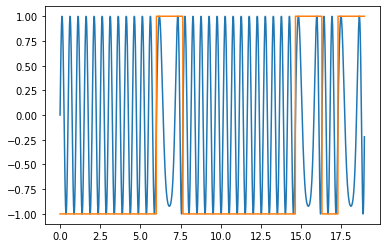

In [29]:
pylab.plot(data_ii/100,data_xx)
pylab.plot(data_ii/100,data_yy)
pylab.show()

#### Рекурентная сеть:

In [30]:
class my_rnn(nn.Module): 
    
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(my_rnn, self).__init__()

        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        self.lin = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
               
        out, hidden = self.rnn(x)
        out = self.lin(out)
        
        return out

In [27]:
dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(data_xx,
                                                                        data_yy),
                           batch_size = 32,
                           shuffle = False,
                           drop_last = True)

In [28]:
model = my_rnn(1,1,10,1)

In [29]:
def train(net,dataloader,n_epochs,lr,
         optimiser = torch.optim.SGD,
         criterion = torch.nn.MSELoss()
         ):
    
    optim = optimiser(model.parameters(),lr=lr)
    
    arr = []
    for i in tqdm(range(n_epochs)):
        for data,labels in dataloader:
            optim.zero_grad()
            #print(model(data))
            loss = criterion(model(data),labels)
            loss.backward()
            optim.step()

        arr.append([i,
                    loss.detach().numpy(),
                   ])

    return np.array(arr)

In [30]:
arr = train(model,dataloader,1000,0.1)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:39<00:00,  3.13it/s]


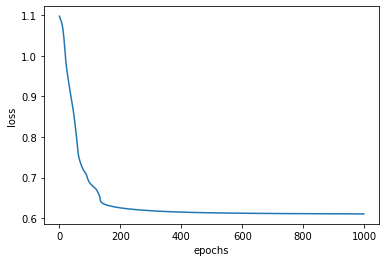

In [32]:
pylab.ylabel("loss")
pylab.xlabel("epochs")
pylab.plot(arr[:,0],arr[:,1])
pylab.show()

In [51]:
bd = 0
arr_rs = []
for t in dataloader:
    arr_rs.append((model(t[0]).detach().numpy() > bd) * 2 - 1)
        
arr_rs = np.array(arr_rs).flatten()

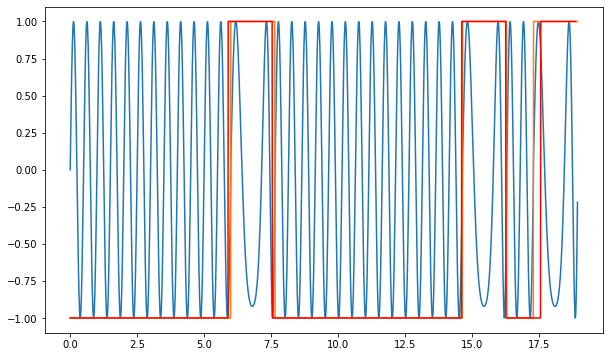

In [54]:
pylab.figure(figsize=(10, 6))

pylab.plot(data_ii/100,data_xx)
pylab.plot(data_ii/100,data_yy)
pylab.plot(data_ii[0:1888]/100,arr_rs[0:1888],color = "red")
pylab.show()

### Задание 2. Рекурентная сеть Хопфилда

In [245]:
def visualise(matr): #представить двумерный массив в виде черно-белой картинки
    pylab.figure(figsize = (matr.shape[1]/10,matr.shape[0]/10))
    for i in range(matr.shape[0]):
        for j in range(matr.shape[1]):
            if(matr[i,j] > 0):
                pylab.plot(j,matr.shape[0] - i,'s',color = (1,1,1))
            else:
                pylab.plot(j,matr.shape[0] - i,'s',color = (0,0,0))
    pylab.show()

In [246]:
def corrupt(matr,prob): #с вероятностью prob заменить значения пикселей на противоположные
    thresh = 1 - prob
    res = copy.deepcopy(matr)
    for i in range(matr.shape[0]):
        for j in range(matr.shape[1]):
            if(np.random.random() > thresh):
                res[i][j] = -1*res[i][j]
    return res

In [247]:
class hopfieldRNN():
    def __init__ (self, input_size,threshold = 0):
        self.vector_len = input_size[0]*input_size[1]
        self.img_size = input_size
        self.wts = np.zeros([self.vector_len,self.vector_len])
        self.thresh = threshold
        
    def memorize(self, input):
        tmp = input.flatten()
        
        self.wts += np.outer(tmp,tmp)
    
    def recall(self, input):
        tmp = input.flatten()
        res = np.zeros(self.vector_len)
        
        for i in range(len(tmp)):
            sum_row = np.array(self.wts[:,i] * tmp).sum()
            if(sum_row > self.thresh):
                res[i] = 1
            else:
                res[i] = -1
        return res.reshape(self.img_size)        

In [191]:
img_9 = np.array([
    [1,1,1,1,-1,-1,-1,-1,-1,-1],
    [1,1,1,1,-1,-1,-1,-1,-1,-1],
    [1,1,1,1,-1,-1,1,1,-1,-1],
    [1,1,1,1,-1,-1,1,1,-1,-1],
    [1,1,1,1,-1,-1,1,1,-1,-1],
    [1,1,1,1,-1,-1,1,1,-1,-1],
    [1,1,1,1,-1,-1,-1,-1,-1,-1],
    [1,1,1,1,-1,-1,-1,-1,-1,-1],
    [1,1,1,1,1,1,1,1,-1,-1],
    [1,1,1,1,1,1,1,1,-1,-1],
    [1,1,1,1,-1,-1,-1,-1,-1,-1],
    [1,1,1,1,-1,-1,-1,-1,-1,-1]
])

img_6 = np.array([
    [-1,-1,-1,-1,-1,-1,1,1,1,1],
    [-1,-1,-1,-1,-1,-1,1,1,1,1],
    [-1,-1,1,1,1,1,1,1,1,1],
    [-1,-1,1,1,1,1,1,1,1,1],
    [-1,-1,-1,-1,-1,-1,1,1,1,1],
    [-1,-1,-1,-1,-1,-1,1,1,1,1],
    [-1,-1,1,1,-1,-1,1,1,1,1],
    [-1,-1,1,1,-1,-1,1,1,1,1],
    [-1,-1,1,1,-1,-1,1,1,1,1],
    [-1,-1,1,1,-1,-1,1,1,1,1],
    [-1,-1,-1,-1,-1,-1,1,1,1,1],
    [-1,-1,-1,-1,-1,-1,1,1,1,1]
])

img_1 = np.array([
    [1,1,1,-1,-1,-1,-1,1,1,1],
    [1,1,1,-1,-1,-1,-1,1,1,1],
    [1,1,1,-1,-1,-1,-1,1,1,1],
    [1,1,1,-1,-1,-1,-1,1,1,1],
    [1,1,1,-1,-1,-1,-1,1,1,1],
    [1,1,1,-1,-1,-1,-1,1,1,1],
    [1,1,1,-1,-1,-1,-1,1,1,1],
    [1,1,1,-1,-1,-1,-1,1,1,1],
    [1,1,1,-1,-1,-1,-1,1,1,1],
    [1,1,1,-1,-1,-1,-1,1,1,1],
    [1,1,1,-1,-1,-1,-1,1,1,1],
    [1,1,1,-1,-1,-1,-1,1,1,1]
])


##### Изображения

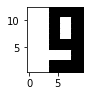

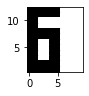

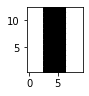

In [192]:
visualise(img_9)
visualise(img_6)
visualise(img_1)

##### Искаженные изображения

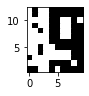

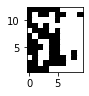

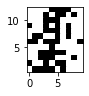

In [193]:
test_1 = corrupt(img_9,0.1)
test_2 = corrupt(img_6,0.2)
test_3 = corrupt(img_1,0.3)

visualise(test_1)
visualise(test_2)
visualise(test_3)

In [194]:
hRNN = hopfieldRNN(img_9.shape)
hRNN.memorize(img_9)
hRNN.memorize(img_6)
hRNN.memorize(img_1)

##### Восстановленные сетью изображения

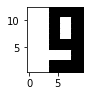

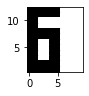

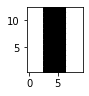

In [195]:
visualise(hRNN.recall(test_1))
visualise(hRNN.recall(test_2))
visualise(hRNN.recall(test_3))

###### Если исказить изображения сильнее, то можно наблюдать более интересное поведение:

##### Восстановление обратного изображения.

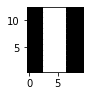

In [198]:
test_4 = corrupt(img_9,0.4)
visualise(hRNN.recall(test_4))

##### Восстановление в 2 шага.

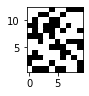

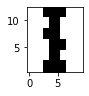

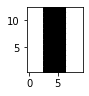

In [226]:
test_4 = corrupt(img_9,0.4)
tmp = test_4
visualise(tmp)
for i in range(2):
    tmp = hRNN.recall(tmp)
    visualise(tmp)

##### Стабильное состояние, являющееся комбинацией обучающих примеров.

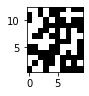

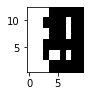

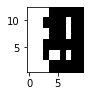

In [244]:
test_4 = corrupt(img_9,0.5)
tmp = test_4
visualise(tmp)
for i in range(2):
    tmp = hRNN.recall(tmp)
    visualise(tmp)

### Задание 3. Рекурентная сеть Хэмминга

In [248]:
def activation(x):
    if(x > 1):
        return 1
    if(x < 0):
        return 0
    return x

In [322]:
class hammingRNN():
    def __init__ (self, input_size,threshold = 0):
        self.vector_len = input_size[0]*input_size[1]
        self.img_size = input_size
        self.thresh = threshold
        
    def train(self, inputs):
        wts = []
        for inp in inputs:
            wts.append(inp.flatten())
        self.wts = np.array(wts)
    
    def identify(self, input, iterations = 5, verbal = False):
        tmp = input.flatten()
        res = np.matmul(self.wts,tmp) / tmp.shape #нормализация
        out = copy.deepcopy(res)
        
        if(verbal):
            print(out)
        for _ in range(iterations):
            for j in range(len(out)):
                for i in range(len(out)):
                    if(i != j):
                        out[j] -= (1/len(out)) * out[i]
                    else:
                        out[j] += out[i]
                                        
                out[j] = activation(out[j])
                
            if(verbal):
                print(out)
                
        return np.argmax(out)
        

In [323]:
hmRNN = hammingRNN(img_9.shape)
hmRNN.train([img_9,img_6,img_1])

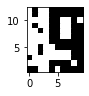

0


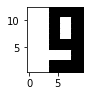

-----------------------------------------------------------


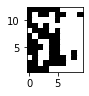

1


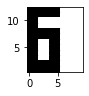

-----------------------------------------------------------


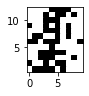

2


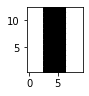

In [331]:
visualise(test_1)
print(hmRNN.identify(test_1))
visualise(hmRNN.wts[hmRNN.identify(test_1)].reshape(test_1.shape))
print("-----------------------------------------------------------")
visualise(test_2)
print(hmRNN.identify(test_2))
visualise(hmRNN.wts[hmRNN.identify(test_2)].reshape(test_2.shape))
print("-----------------------------------------------------------")
visualise(test_3)
print(hmRNN.identify(test_3))
visualise(hmRNN.wts[hmRNN.identify(test_3)].reshape(test_3.shape))

### Вывод

В ходе выполнения этой лабораторной работы я ознакомился с рекурентными сетями Хопфилда, Хэмминга и Элмана, а также получил опыт в их использовании для решения задач распознания статических и динамических образов